In [2]:
path = 'data/GrowthProfilerResults_Long_Pretest.csv'

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df=pd.read_csv(path)

In [ ]:
# Count unique replicates per Media and Condition
# Useful check considering you might want to manipulate replicates/outliers or when some experiments/runs fail.
df.groupby(['Condition', 'Media'])['Replicate'].nunique()

In [ ]:
def plot_growth_curves (df, x='Time', y='OD600', hue='Media', style='Condition', ci_level=95):

    """
    Plots growth curves with confidence intervals using seaborn.

    Parameters:
    - df: pandas DataFrame containing the data
    - x: column name for x-axis (default 'Time')
    - y: column name for y-axis (default 'OD600')
    - hue: column name for grouping by color (default 'Media')
    - style: column name for line style (default 'Condition')
    - ci_level: confidence interval level (default 95)
    """

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x=x, y=y, hue=hue, style=style, errorbar =('ci', ci_level))
    plt.title(f'Growth curves by {hue} and {style} - CI({ci_level})')
    plt.ylabel(y)
    plt.xlabel(f'{x} (hours)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


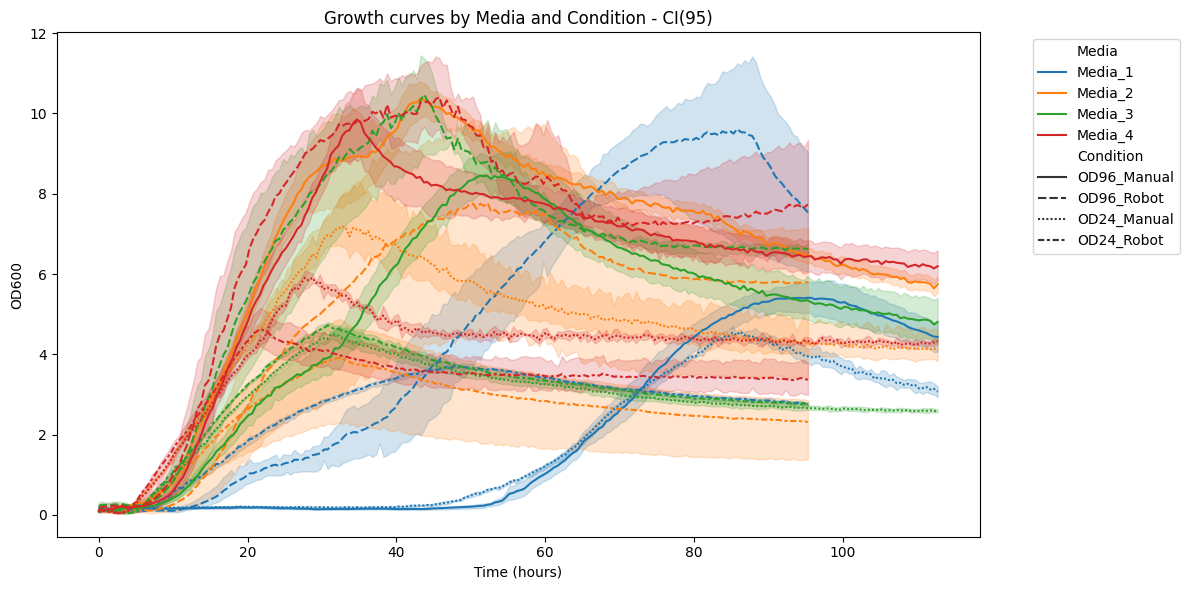

In [28]:
plot_growth_curves(df)

In [43]:
from scipy.stats import levene

# Subset for one condition (e.g., OD96_manual)
subset = df[df['Condition'] == 'OD96_Manual']
groups = [group['OD600'].values for name, group in subset.groupby('Media')]

stat, p = levene(*groups)
print(f"Levene’s test: stat={stat:.3f}, p={p:.4f}")


Levene’s test: stat=8.289, p=0.0000


In [ ]:
# linear models or mixed models are more robust when n is unequal 

#This needs to be rewritten to consider time.

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

model = smf.ols('OD600 ~ Media + Condition + Media:Condition', data=df).fit()
anova_table = anova_lm(model, typ=2)
print(anova_table)

                       sum_sq       df            F  PR(>F)
Media            21938.040207      3.0  1251.622239     0.0
Condition        18431.430857      3.0  1051.561057     0.0
Media:Condition  10382.398412      9.0   197.447609     0.0
Residual         96764.505718  16562.0          NaN     NaN


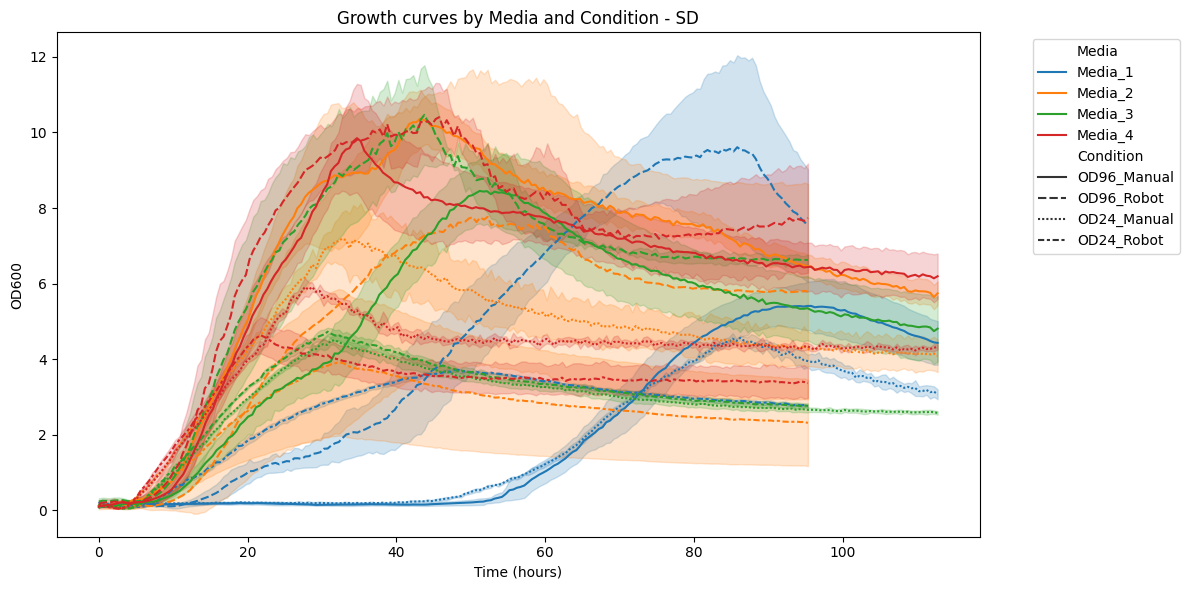

In [ ]:

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Time', y='OD600', hue='Media', style='Condition', errorbar = 'sd') #errorbar='sd' or errorbar=('ci',95)
plt.title('Growth curves by Media and Condition - SD')
plt.ylabel('OD600')
plt.xlabel('Time (hours)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [18]:
# Count unique replicates per Media and Condition
df.groupby(['Condition', 'Media'])['Replicate'].nunique()


Condition    Media  
OD24_Manual  Media_1    3
             Media_2    3
             Media_3    3
             Media_4    3
OD24_Robot   Media_1    3
             Media_2    6
             Media_3    3
             Media_4    3
OD96_Manual  Media_1    9
             Media_2    9
             Media_3    9
             Media_4    9
OD96_Robot   Media_1    3
             Media_2    6
             Media_3    3
             Media_4    3
Name: Replicate, dtype: int64

In [16]:
from scipy.stats import f_oneway

# Let's look at final OD600 (last time point) per condition
final_time = df['Time'].max()
subset = df[df['Time'] == final_time]

# Example: one-way ANOVA within a single condition
cond_df = subset[subset['Condition'] == 'OD96_Robot']

f_stat, p_val = f_oneway(
    *[group['OD600'].values for name, group in cond_df.groupby('Media')]
)

print(f"ANOVA for OD96_robot at final time:")
print(f"F = {f_stat:.3f}, p = {p_val:.4e}")


TypeError: At least two samples are required; got 0.

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Just use final OD600 for this example
model_df = subset.copy()

# Convert to categorical
model_df['Media'] = model_df['Media'].astype('category')
model_df['Condition'] = model_df['Condition'].astype('category')

# Fit model
model = smf.ols('OD600 ~ Media + Condition + Media:Condition', data=model_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                    sum_sq    df          F        PR(>F)
Media            23.242943   3.0  24.154370  4.386659e-09
Condition        28.480011   1.0  88.790397  1.042172e-11
Media:Condition   0.908447   3.0   0.944070  4.284464e-01
Residual         12.830221  40.0        NaN           NaN


In [42]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['OD600'], groups=df['Media'] + "_" + df['Condition'], alpha=0.05)
print(tukey.summary())


             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------
Media_1_OD24_Manual  Media_1_OD24_Robot   0.8366    0.0  0.3666  1.3066   True
Media_1_OD24_Manual Media_1_OD96_Manual   0.3047  0.245 -0.0626   0.672  False
Media_1_OD24_Manual  Media_1_OD96_Robot   2.8728    0.0  2.4028  3.3428   True
Media_1_OD24_Manual Media_2_OD24_Manual   2.7817    0.0  2.3318  3.2315   True
Media_1_OD24_Manual  Media_2_OD24_Robot   0.7878    0.0  0.3865  1.1891   True
Media_1_OD24_Manual Media_2_OD96_Manual   4.9287    0.0  4.5614   5.296   True
Media_1_OD24_Manual  Media_2_OD96_Robot   3.2841    0.0  2.8828  3.6854   True
Media_1_OD24_Manual Media_3_OD24_Manual   1.0846    0.0  0.6348  1.5344   True
Media_1_OD24_Manual  Media_3_OD24_Robot   1.2758    0.0  0.8058  1.7458   True
Media_1_OD24_Manual Media_3_OD96_Manual   3.2349    

In [15]:
import statsmodels.formula.api as smf

# Example: fit mixed model
# Assuming each unique replicate is identified (e.g., by combining Media + Replicate + Condition)

df['Subject'] = df['Media'] + "_" + df['Replicate'].astype(str) + "_" + df['Condition']

model = smf.mixedlm("OD600 ~ Time * Media * Condition", df, groups=df["Subject"])
result = model.fit()
print(result.summary())


                          Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            OD600      
No. Observations:            16578              Method:                        REML       
No. Groups:                  78                 Scale:                         3.3616     
Min. group size:             191                Log-Likelihood:                -33792.8555
Max. group size:             226                Converged:                     Yes        
Mean group size:             212.5                                                        
------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                      -0.794    0.529  -1.500 0.134 -1.830  0.243
Media[T.Media_2]          